In [14]:
# Standard
import os
import joblib

# Third-party
import deepchem as dc
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from optuna.samplers import TPESampler
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.model_selection import cross_val_score

# Own-coded
from measurements import nRMSE
from utils import get_similarity, load_bace

# Make all the figures have Times New Roman font, and 16 font size
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16


# Studying Ways of visualization and featurization of SMILES strings

Notebook to save experiments for the ECFP4 featurization of the molecules and their posterior use for training Linear regression models such as:

- Linear Regression.
- Lasso Regression.
- Ridge Regression.

To do this, we will be using a Random Split. 

In [3]:
# Load BACE regression dataset
dfs = load_bace(splitter = dc.splits.RandomSplitter())
df_train, df_valid, df_test = dfs
smiles = df_train.smiles.values.tolist()
similarity_matrix, fingerprints, mols = get_similarity(smiles)
df = pd.DataFrame(similarity_matrix, index=smiles, columns=smiles)

df_train = df_train.set_index('smiles')
df_valid = df_valid.set_index('smiles')
df_test = df_test.set_index('smiles')


## Loading the Data:


In [4]:
# Now it's time to train a Linear Regression model with the Fingerprints
# Let's use the Linear Regression model from sklearn

# Train the model
X = df_train.drop(columns=['targets'])
y = df_train.targets.values
x_valid = df_valid.drop(columns=['targets'])
y_valid = df_valid.targets.values
# X and x_valid are the new X_train
# y and y_valid are the new y_train
X_train = pd.concat([X, x_valid])
y_train = np.concatenate([y, y_valid])
x_test = df_test.drop(columns=['targets'])
y_test = df_test.targets.values

# Linear Models:

## Optuna search, Lasso:

Here we will be performing hyperparameter optimization for the Lasso Regression

In [5]:
def objective(trial):
    # Alpha is the regularization parameter
    # the bigger it is, the the more the model will be penalized
    # 
    # The objective is: (1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1
    # 
    # Alpha shall be between 0 and 10000 and it will be chosen in a log scale
    alpha = trial.suggest_float('alpha', 1e-4, .1)
    # Cross-validate the model
    reg = Lasso(alpha=alpha, max_iter=int(1e4))
    # Perform cross-validation
    scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='r2')
    

    return np.mean(scores)

sampler = TPESampler(seed=10)
study = optuna.create_study(direction='maximize', sampler=sampler,
                            study_name='lasso')
study.optimize(objective, n_trials=100, n_jobs=-1)
print(study.best_params)
print(study.best_value)
print(study.best_trial)


[I 2024-09-08 20:10:59,378] A new study created in memory with name: lasso
/Users/cesarasa/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2024-09-08 20:11:00,559] Trial 0 finished with value: 0.3991016028332345 and parameters: {'alpha': 0.028610108739623642}. Best is trial 0 with value: 0.3991016028332345.
[I 2024-09-08 20:11:00,809] Trial 9 finished with value: 0.0727280905078405 and parameters: {'alpha': 0.0974183549087996}. Best is trial 0 with value: 0.3991016028332345.
[I 2024-09-08 20:11:00,814] Trial 5 finished with value: 0.23586641072804615 and parameters: {'alpha': 0.05771964443713311}. Best is trial 0 with value: 0.3991016028332345.
[I 2024-09-08 20:11:00,831] Trial 7 finished with value: 0.1816586885048848 and parameters: {'alpha': 0.0677110488614598}. Best is t

{'alpha': 0.0020592054996987417}
0.6656160988429424
FrozenTrial(number=30, values=[0.6656160988429424], datetime_start=datetime.datetime(2024, 9, 8, 20, 11, 8, 306941), datetime_complete=datetime.datetime(2024, 9, 8, 20, 11, 18, 380216), params={'alpha': 0.0020592054996987417}, distributions={'alpha': UniformDistribution(high=0.1, low=0.0001)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=30, state=TrialState.COMPLETE, value=None)


Train nRMSE: 0.4463
Test nRMSE: 0.5050
Train R2: 0.8008
Test R2: 0.7450
Train PCC: 0.8974
Test PCC: 0.8672


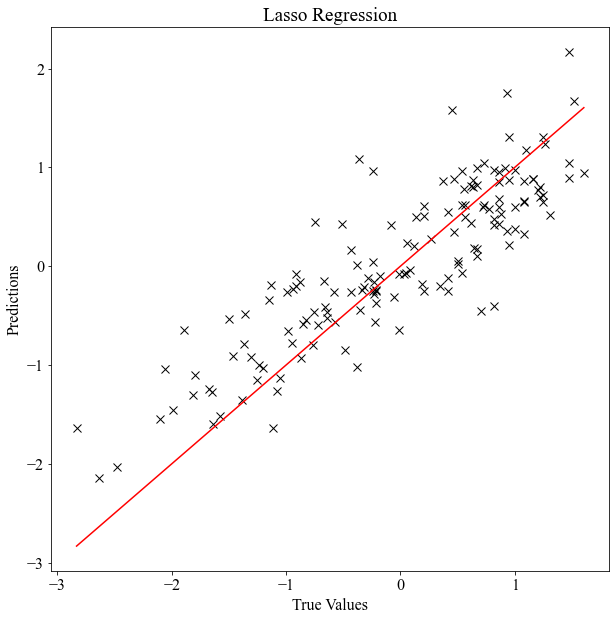

In [15]:
X_train = pd.concat([X, x_valid])
y_train = np.concatenate([y, y_valid])

# Train with X_train and y_train, using best parameters:
reg = Lasso(alpha=0.002, max_iter=int(1e4))
reg.fit(X_train, y_train)

# Predict and compute the nRMSE for train and test set
y_pred_train = reg.predict(X_train)
nrmse, r2, mse, rmse = nRMSE(y_train, y_pred_train)

y_pred_test = reg.predict(x_test)
nrmse_test, r2_test, mse_test, rmse_test = nRMSE(y_test, y_pred_test)

# Print:
print(f'Train nRMSE: {nrmse:.4f}')
print(f'Test nRMSE: {nrmse_test:.4f}')
print(f'Train R2: {r2:.4f}')
print(f'Test R2: {r2_test:.4f}')
# Print PCC
pcc = np.corrcoef(y_train, y_pred_train)[0, 1]
print(f'Train PCC: {pcc:.4f}')
pcc_test = np.corrcoef(y_test, y_pred_test)[0, 1]
print(f'Test PCC: {pcc_test:.4f}')

# Plot predictions vs true values
plt.figure(figsize=(10, 10))
plt.plot(y_test, y_pred_test, 'kx', markersize=8)
# Plot line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Lasso Regression')

# Create figures folder
if not os.path.exists('figures'):
    os.makedirs('figures')
plt.savefig('figures/lasso_regression_plot.png')
plt.show()

## Optuna search, Ridge

Here we sill be performing HPO for the Ridge Regression. 

In [7]:
def objective(trial):
    # Alpha is the regularization parameter
    # the bigger it is, the the more the model will be penalized
    # 
    # The objective is: (1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1
    # 
    # Alpha shall be between 0 and 10000 and it will be chosen in a log scale
    alpha = trial.suggest_float('alpha', 1e-1, 100)
    # Cross-validate the model
    reg = Ridge(alpha=alpha, max_iter=int(1e4))
    # Perform cross-validation
    scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='r2')
    

    return np.mean(scores)

sampler = TPESampler(seed=10)
study2 = optuna.create_study(direction='maximize', sampler=sampler,
                            study_name='ridge')
study2.optimize(objective, n_trials=100, n_jobs=-1)
print(study2.best_params)
print(study2.best_value)
print(study2.best_trial)

[I 2024-09-08 20:13:35,089] A new study created in memory with name: ridge
/Users/cesarasa/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2024-09-08 20:13:39,448] Trial 6 finished with value: 0.6855944542632779 and parameters: {'alpha': 13.15838772999109}. Best is trial 6 with value: 0.6855944542632779.
[I 2024-09-08 20:13:39,499] Trial 8 finished with value: 0.6419889675669422 and parameters: {'alpha': 95.2918861782518}. Best is trial 6 with value: 0.6855944542632779.
[I 2024-09-08 20:13:39,552] Trial 9 finished with value: 0.6861659122891908 and parameters: {'alpha': 21.33588770828758}. Best is trial 9 with value: 0.6861659122891908.
[I 2024-09-08 20:13:39,553] Trial 0 finished with value: 0.686028623086876 and parameters: {'alpha': 21.842048134556972}. Best is trial 9 wi

{'alpha': 17.858604255600813}
0.6867013665983297
FrozenTrial(number=71, values=[0.6867013665983297], datetime_start=datetime.datetime(2024, 9, 8, 20, 14, 4, 83573), datetime_complete=datetime.datetime(2024, 9, 8, 20, 14, 8, 554544), params={'alpha': 17.858604255600813}, distributions={'alpha': UniformDistribution(high=100.0, low=0.1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=71, state=TrialState.COMPLETE, value=None)


Train nRMSE: 0.3866
Test nRMSE: 0.5062
Train R2: 0.8506
Test R2: 0.7438
Train PCC: 0.9252
Test PCC: 0.8646


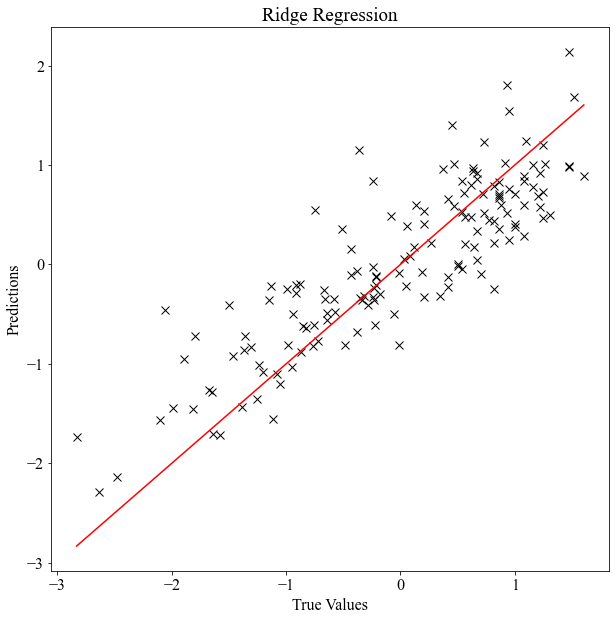

In [16]:
X_train = pd.concat([X, x_valid])
y_train = np.concatenate([y, y_valid])
# Train with X_train and y_train, using best parameters:
reg2 = Ridge(alpha=15, max_iter=int(1e4))
reg2.fit(X_train, y_train)

# Predict and compute the nRMSE for train and test set
y_pred_train = reg2.predict(X_train)
nrmse, r2, mse, rmse = nRMSE(y_train, y_pred_train)

y_pred_test = reg2.predict(x_test)
nrmse_test, r2_test, mse_test, rmse_test = nRMSE(y_test, y_pred_test)

# Print:
print(f'Train nRMSE: {nrmse:.4f}')
print(f'Test nRMSE: {nrmse_test:.4f}')
print(f'Train R2: {r2:.4f}')
print(f'Test R2: {r2_test:.4f}')
pcc = np.corrcoef(y_train, y_pred_train)[0, 1]
print(f'Train PCC: {pcc:.4f}')
pcc_test = np.corrcoef(y_test, y_pred_test)[0, 1]
print(f'Test PCC: {pcc_test:.4f}')


# Plot predictions vs true values
plt.figure(figsize=(10, 10))
plt.plot(y_test, y_pred_test, 'kx', markersize=8)
# Plot line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Ridge Regression')
plt.savefig('figures/ridge_regression_plot.png')
plt.show()

Train nRMSE: 0.1997
Test nRMSE: 105380.4241
Train R2: 0.9601
Test R2: -11105033775.2669
Train PCC: 0.9799
Test PCC: 0.0733


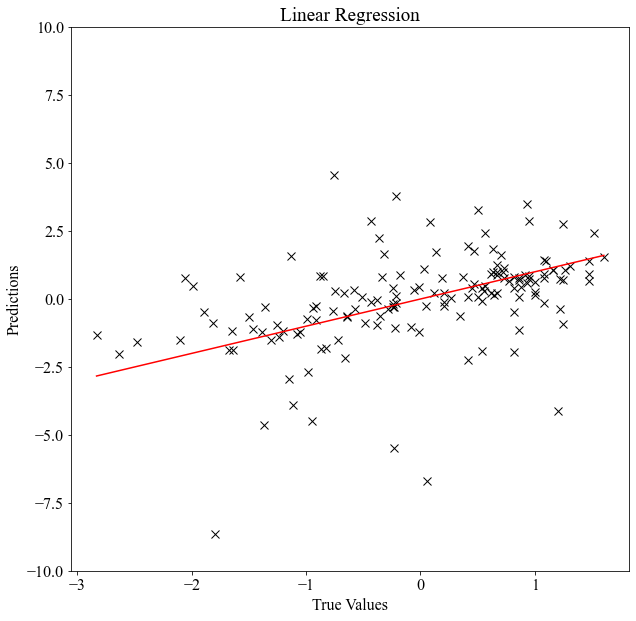

In [17]:
# Linear Regression:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict and compute the nRMSE for train and test set
y_pred_train = lr.predict(X_train)
nrmse, r2, mse, rmse = nRMSE(y_train, y_pred_train)

y_pred_test = lr.predict(x_test)
nrmse_test, r2_test, mse_test, rmse_test = nRMSE(y_test, y_pred_test)

# Print:
print(f'Train nRMSE: {nrmse:.4f}')
print(f'Test nRMSE: {nrmse_test:.4f}')
print(f'Train R2: {r2:.4f}')
print(f'Test R2: {r2_test:.4f}')
pcc = np.corrcoef(y_train, y_pred_train)[0, 1]
print(f'Train PCC: {pcc:.4f}')
pcc_test = np.corrcoef(y_test, y_pred_test)[0, 1]
print(f'Test PCC: {pcc_test:.4f}')

# Plot predictions vs true values
plt.figure(figsize=(10, 10))
plt.plot(y_test, y_pred_test, 'kx', markersize=8)
# Plot line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.ylim(-10, 10)
plt.title('Linear Regression')
plt.savefig('figures/linear_regression_plot.png')
plt.show()

In [18]:
# Print y_test and y_pred_test as two columns
df = pd.DataFrame(index=df_test.index, data={'y_test': y_test, 'y_pred_test': y_pred_test})
df.to_excel('predictions.xlsx')
# Find largest y_pred_test
max_idx = np.argmax(y_pred_test-y_test)
print(f'Worst y_pred_test: {y_pred_test[max_idx]}')
print(f'Which Molecule? {df_test.index[max_idx]}')
print(f'With target: {y_test[max_idx]}')

Worst y_pred_test: 1292068.6779205233
Which Molecule? Fc1ncccc1-c1cc(ccc1)C1(N=C(N)N(C)C1=O)c1cn(nc1)CC(CC)CC
With target: 0.860721206430285


In [12]:
# Save studies in pickle and csv
study_path = 'studies'
if not os.path.exists(study_path):
    os.makedirs(study_path)
    
study2_path = 'studies/ridge_study.pkl'
study_path = 'studies/lasso_study.pkl'

joblib.dump(study, study_path)
joblib.dump(study2, study2_path)

study2_df = study2.trials_dataframe()
study_df = study.trials_dataframe()

study2_df.to_csv('studies/ridge_study.csv')
study_df.to_csv('studies/lasso_study.csv')


# Conclusion:

The Linear Regression is failing on the test set, even when we do it using Random Split. Thus, we are assuming it will fail in the Scaffold setup. 